### Conditional density estimation

The model is as follows:
$$\mu \sim \text{Uniform}(-2, 2)$$
$$x_i \sim N(\mu, 1) \quad \text{for}\ i\ \text{in}\ 1,2$$

We will try to infer the conditional distribution $p(x|\mu)$ using a conditional normalizing flow. For more examples of architectures, see unconditional_examples.ipynb. Here, we will use a `RationalQuadraticSplineTransformer` bijection with a `MaskedAutoregressiveFlow` architecture.


In [1]:
from jax import random
import jax.numpy as jnp
from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.transformers import RationalQuadraticSplineTransformer
from flowjax.distributions import Normal
from flowjax.train_utils import train_flow
import matplotlib.pyplot as plt

In [2]:
key, x_key, cond_key = random.split(random.PRNGKey(0), 3)
cond = random.uniform(cond_key, (10000, 1), minval=-2, maxval=2)
x = random.normal(x_key, (10000, 2)) + cond

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
key, subkey = random.split(key)

flow = MaskedAutoregressiveFlow(
    key=subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    transformer=RationalQuadraticSplineTransformer(K=8, B=4),  # 8 spline segments.
    cond_dim=cond.shape[1],
)

key, subkey = random.split(key)
flow, losses = train_flow(subkey, flow, x, cond)

 32%|███▏      | 16/50 [00:19<00:41,  1.22s/it, train=2.89, val=2.91 (Max patience reached)]


#### Sampling
We can now sample from the flow, for example conditioning on $\mu = 1$, which should be approximately a two dimensional $N(1, 1)$.


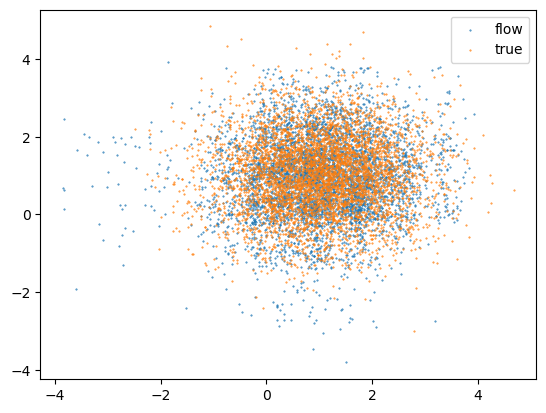

In [4]:
n = 5000
key, flow_key, true_key = random.split(key, 3)
mu = jnp.array([1])
sample = flow.sample(flow_key, condition=mu, n=n)
true = random.normal(true_key, sample.shape) + 1
plt.scatter(x=sample[:, 0], y=sample[:, 1], s=0.2, label="flow")
plt.scatter(x=true[:, 0], y=true[:, 1], s=0.2, label="true")
plt.legend()

Alternatively, we can provide a matrix of conditioning variables, to sample once for each row of the conditioning variable. For example, using $\mu \in [-2, 2]$

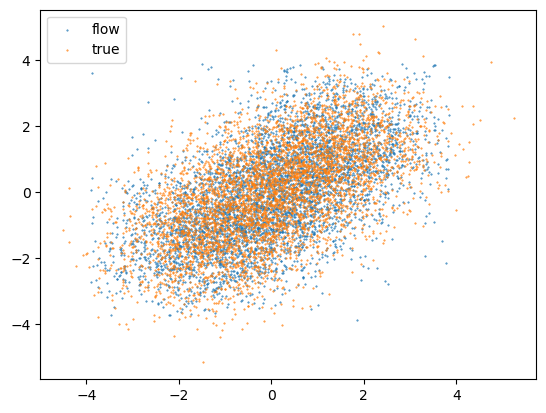

In [5]:
key, flow_key, true_key = random.split(key, 3)
mu = jnp.linspace(-2, 2, n)[:, None]
sample = flow.sample(flow_key, condition=mu)
true = random.normal(true_key, sample.shape) + mu
plt.scatter(x=sample[:, 0], y=sample[:, 1], s=0.2, label="flow")
plt.scatter(x=true[:, 0], y=true[:, 1], s=0.2, label="true")
plt.legend()

#### Density evaluation
We can evaluate the density at arbitrary points

In [6]:
print(
    flow.log_prob(sample[:5], condition=mu[:5])
)  # Inputs and conditions matched across rows
print(
    flow.log_prob(sample[:5], condition=mu[-1])
)  # Several inputs with specific condition
print(
    flow.log_prob(sample[0], condition=mu[:5])
)  # Specific input with several conditions

[-2.6615756 -1.7644163 -3.6128519 -3.8382297 -3.7205007]
[ -8.676789  -12.332783   -9.1115055 -12.327751   -8.04962  ]
[-2.6615756 -2.6610217 -2.660474  -2.6599324 -2.6593938]
